In [29]:
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

In [30]:
df = pd.read_csv('fashion.csv')
df.head()

,date,Cami Dresses,Shirts,Tote Bags,Sneakers,Crop Tops,Polos,Cross Body Bags,Casual Jackets,Swimwear,...,Heels,T-Shirts,Activewear Tops & T-Shirts,Watches & Timepieces,Wallets & Card Holders,Bodycon Dresses,Beauty Tools & Accessories,Skinny Jeans,Beauty Eyes,Beauty Face
0,2017-08-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-08-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df = df.iloc[:,1:]
df_copy = df.copy()

In [32]:
num_layers = 1
learning_rate = 0.01
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_weeks = 30

In [33]:
class Model:
    def __init__(self, learning_rate, num_layers, 
                 size, size_layer, forget_bias = 0.8):
        
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(size_layer) for _ in range(num_layers)], 
                                                state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, size))
        drop = tf.contrib.rnn.DropoutWrapper(rnn_cells, output_keep_prob = forget_bias)
        self.hidden_layer = tf.placeholder(tf.float32, 
                                           (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(drop, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        self.logits = tf.layers.dense(self.outputs[-1],size,
                       kernel_initializer=tf.glorot_uniform_initializer())
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.Y,logits=self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [34]:
tf.reset_default_graph()
modelnn = Model(learning_rate, num_layers, df.shape[1], size_layer, dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

d:\ML\fashion-trends-pred\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [35]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (df.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df.iloc[k: k + timestamp].values, axis = 0)
        batch_y = df.iloc[k + 1: k + timestamp + 1].values
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (df.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.02088155942679993
epoch: 200 avg loss: 0.014711900784810683
epoch: 300 avg loss: 0.011011939688489354
epoch: 400 avg loss: 0.007854407217658671
epoch: 500 avg loss: 0.012112859068016906


In [36]:
output_predict = np.zeros((df.shape[0] + future_weeks, df.shape[1]))
output_predict[0, :] = df.iloc[0] 
upper_b = (df.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([tf.nn.sigmoid(modelnn.logits), modelnn.last_state], 
                                      feed_dict = {modelnn.X:np.expand_dims(df.iloc[k: k + timestamp], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k + 1: k + timestamp + 1] = out_logits
    
out_logits, last_state = sess.run([tf.nn.sigmoid(modelnn.logits), modelnn.last_state], 
                                  feed_dict = {modelnn.X:np.expand_dims(df.iloc[upper_b:], axis = 0),
                                     modelnn.hidden_layer: init_value})
init_value = last_state
output_predict[upper_b + 1: df.shape[0] + 1] = out_logits
df.loc[df.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1]+timedelta(days=3))

In [37]:
for i in range(future_weeks - 1):
    out_logits, last_state = sess.run([tf.nn.sigmoid(modelnn.logits), modelnn.last_state], feed_dict = 
                                      {modelnn.X:np.expand_dims(df.iloc[-timestamp:], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[df.shape[0], :] = out_logits[-1, :]
    df.loc[df.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1]+timedelta(days=3))

In [38]:
date_ori=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [39]:
index = (-np.round(df.values).sum(axis=0)).argsort()[4:10]
index

array([35,  3, 21, 34, 33, 12], dtype=int64)

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

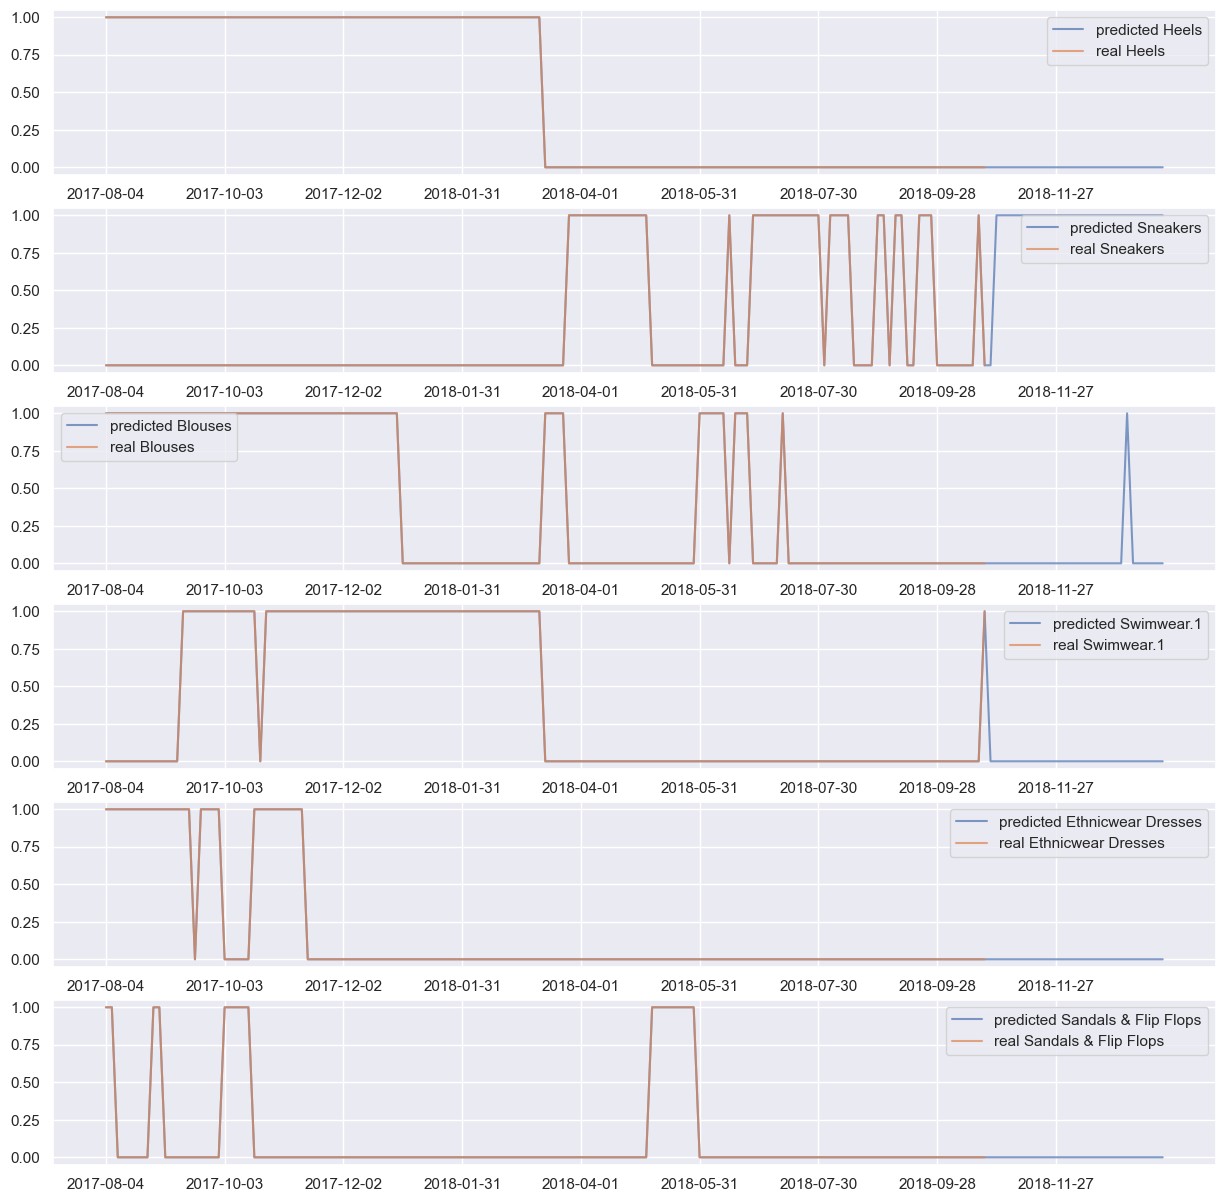

In [41]:
fig = plt.figure(figsize = (15,15))
for no, i in enumerate(index):
    plt.subplot(6,1,no+1)
    label = list(df)[i]
    plt.plot(np.around(df.iloc[:,i]),label='predicted ' + label,alpha=0.7)
    plt.plot(np.around(df_copy.iloc[:,i]),label='real ' + label,alpha=0.7)
    plt.legend()
    x_range_future = np.arange(df.shape[0])
    plt.xticks(x_range_future[::20], date_ori[::20])
plt.show()
plt.show()

In [44]:
def df_shift(df,lag=0,rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        # df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        df = pd.concat([df, dfn], axis=1, join='outer')  # or join='inner' depending on your needs
    return df

In [45]:
df_new = df_shift(df, 2)
df_new.shape

(179, 135)

In [46]:
df_new.head()

,Cami Dresses,Shirts,Tote Bags,Sneakers,Crop Tops,Polos,Cross Body Bags,Casual Jackets,Swimwear,Scarves,...,Bodycon Dresses_1,Bodycon Dresses_2,Beauty Tools & Accessories_1,Beauty Tools & Accessories_2,Skinny Jeans_1,Skinny Jeans_2,Beauty Eyes_1,Beauty Eyes_2,Beauty Face_1,Beauty Face_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df_new = df_new.dropna()

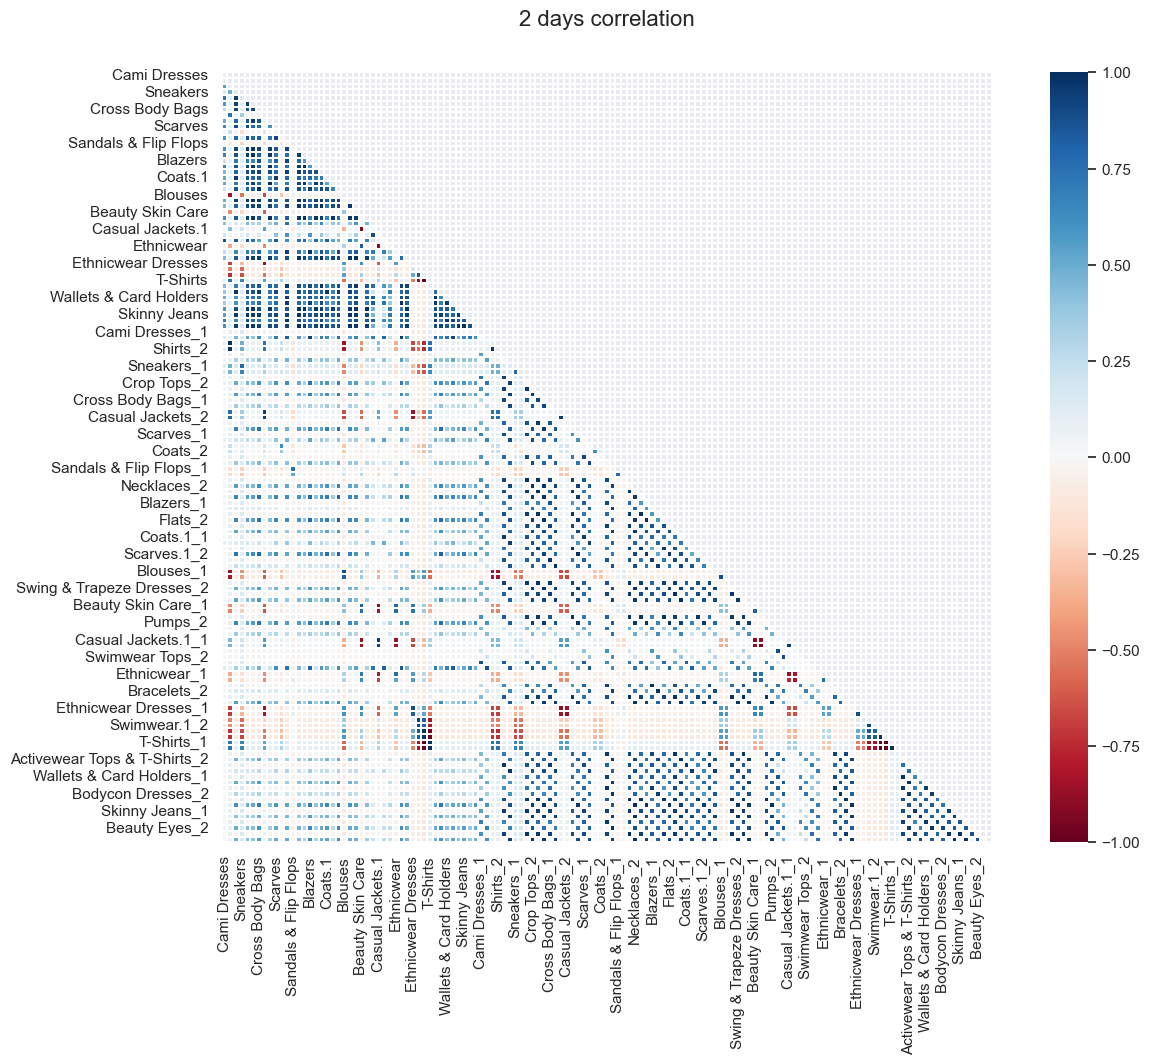

In [48]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title('2 days correlation', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)
plt.show()